# UNet visualization

In [1]:
from unet import UnetGenerator

In [2]:
import torch
from torchsummary import summary

In [4]:
model = UnetGenerator()
summary(model, torch.zeros(32,1,512,512));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 256, 256]        1,088
├─EncoderBlock: 1-2                      [-1, 128, 128, 128]       --
|    └─Sequential: 2-1                   [-1, 128, 128, 128]       --
|    |    └─LeakyReLU: 3-1               [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-2                  [-1, 128, 128, 128]       131,200
|    |    └─BatchNorm2d: 3-3             [-1, 128, 128, 128]       256
├─EncoderBlock: 1-3                      [-1, 256, 64, 64]         --
|    └─Sequential: 2-2                   [-1, 256, 64, 64]         --
|    |    └─LeakyReLU: 3-4               [-1, 128, 128, 128]       --
|    |    └─Conv2d: 3-5                  [-1, 256, 64, 64]         524,544
|    |    └─BatchNorm2d: 3-6             [-1, 256, 64, 64]         512
├─EncoderBlock: 1-4                      [-1, 512, 32, 32]         --
|    └─Sequential: 2-3                   [-1, 512, 32, 32]         --


In [5]:
import numpy as np
ma_path = r"E:\data\input\MA_image\training_body_metalart_img15_512x512x1.raw"  # Replace with your actual path

In [6]:
ma_image = np.fromfile(ma_path, dtype=np.float32).reshape((512, 512))

In [7]:
np.min(ma_image), np.max(ma_image)


(np.float32(-2572.1562), np.float32(24450.227))

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.filters import gaussian
from sklearn.cluster import KMeans

# ——— CONFIG ———
CT_FOLDER    = '/home/user/Desktop/Briya/CONVENTIONAL CT/dataset/body1/body1/baseline_npy'
MASK_FOLDER  = '/home/user/Desktop/Briya/CONVENTIONAL CT/dataset/body1/body1/npy files/MAsk_npy'
MIU_AIR      = 0
MIU_WATER    = 0.19

def linear_attenuation(im, reverse=False):
    if not reverse:
        return MIU_WATER * (1 + im / 1000)
    else:
        return (im / MIU_WATER - 1) * 1000

def circle_mask(im):
    H, W = im.shape
    r = min(H, W) // 2
    yy, xx = np.ogrid[:H, :W]
    return (yy - H//2)**2 + (xx - W//2)**2 > r**2

def proj_interp(proj, metal_trace):
    out = np.zeros_like(proj)
    for i in range(proj.shape[1]):
        row      = proj[:, i].copy()
        mt       = metal_trace[:, i]
        bad_idx  = np.nonzero(mt)[0]
        good_idx = np.where(mt == 0)[0]
        row[bad_idx] = np.interp(bad_idx, good_idx, row[good_idx])
        out[:, i]    = row
    return out

def nmar_proj_interp(proj, proj_prior, metal_trace):
    proj_prior[proj_prior < 0] = 0
    eps = 1e-6
    proj_prior = proj_prior + eps
    proj_norm = proj / proj_prior
    proj_norm_interp = proj_interp(proj_norm, metal_trace)
    proj_nmar = proj_norm_interp * proj_prior
    proj_nmar[metal_trace == 0] = proj[metal_trace == 0]
    return proj_nmar

# pick one slice for demonstration
ct_files = sorted(
    [f for f in os.listdir(CT_FOLDER) if f.endswith('.npy')],
    key=lambda fn: int(re.search(r'_img(\d+)_', fn).group(1))
)
demo_ct   = ct_files[0]
demo_mask = demo_ct.replace('metalart', 'metalonlymask')

# load
im       = np.load(os.path.join(CT_FOLDER, demo_ct)).astype(np.float32)
metal_bw = np.load(os.path.join(MASK_FOLDER, demo_mask)).astype(bool)

# common masks
cm = circle_mask(im)

# prepare for projection
im_raw = linear_attenuation(im)
im_raw[cm] = MIU_AIR
theta = np.linspace(0., 180., im.shape[0], endpoint=False)

# forward project
sino       = radon(im_raw, theta=theta, circle=True)
metal_sino = radon(metal_bw.astype(float), theta=theta, circle=True) > 0

# 1) Linear interpolation correction
sino_li = proj_interp(sino, metal_sino)
im_li   = iradon(sino_li, theta=theta, circle=True, filter_name='ramp')

# 2) NMAR: build prior from LI image
im_prior = im_li.copy()
im_prior[metal_bw] = MIU_WATER
# smooth
im_smooth = gaussian(im_prior, sigma=1)
# k-means segmentation
flat = im_prior.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, init=np.array([[MIU_AIR], [MIU_WATER], [2*MIU_WATER]]), n_init=1)
labels = kmeans.fit_predict(flat).reshape(im.shape)
# thresholds
thresh_bone  = max(1.2*MIU_WATER, np.min(im_prior[labels == 2]))
thresh_water = np.min(im_prior[labels == 1])
# build prior image
prior_img = im_smooth.copy()
prior_img[im_smooth <= thresh_water] = MIU_AIR
mask_bone = (im_smooth > thresh_water) & (im_smooth < thresh_bone)
prior_img[mask_bone] = MIU_WATER

# project prior and apply NMAR
proj_prior = radon(prior_img, theta=theta, circle=True)
sino_nmar  = nmar_proj_interp(sino, proj_prior, metal_sino)
im_nmar    = iradon(sino_nmar, theta=theta, circle=True, filter_name='ramp')

# reconstruct to HU
recon_li   = linear_attenuation(im_li, reverse=True)
recon_nmar = linear_attenuation(im_nmar, reverse=True)
recon_li[metal_bw]   = im[metal_bw]; recon_li[cm]   = im[cm]
recon_nmar[metal_bw] = im[metal_bw]; recon_nmar[cm] = im[cm]

# plot all three
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(im, cmap='gray', vmin=-1000, vmax=2000)
axs[0].set_title('Original CT');      axs[0].axis('off')
axs[1].imshow(np.clip(recon_li, im.min(), im.max()), cmap='gray', vmin=-1000, vmax=2000)
axs[1].set_title('LI-Corrected');      axs[1].axis('off')
axs[2].imshow(np.clip(recon_nmar, im.min(), im.max()), cmap='gray', vmin=-1000, vmax=2000)
axs[2].set_title('NMAR-Corrected');    axs[2].axis('off')
plt.tight_layout()
plt.show()


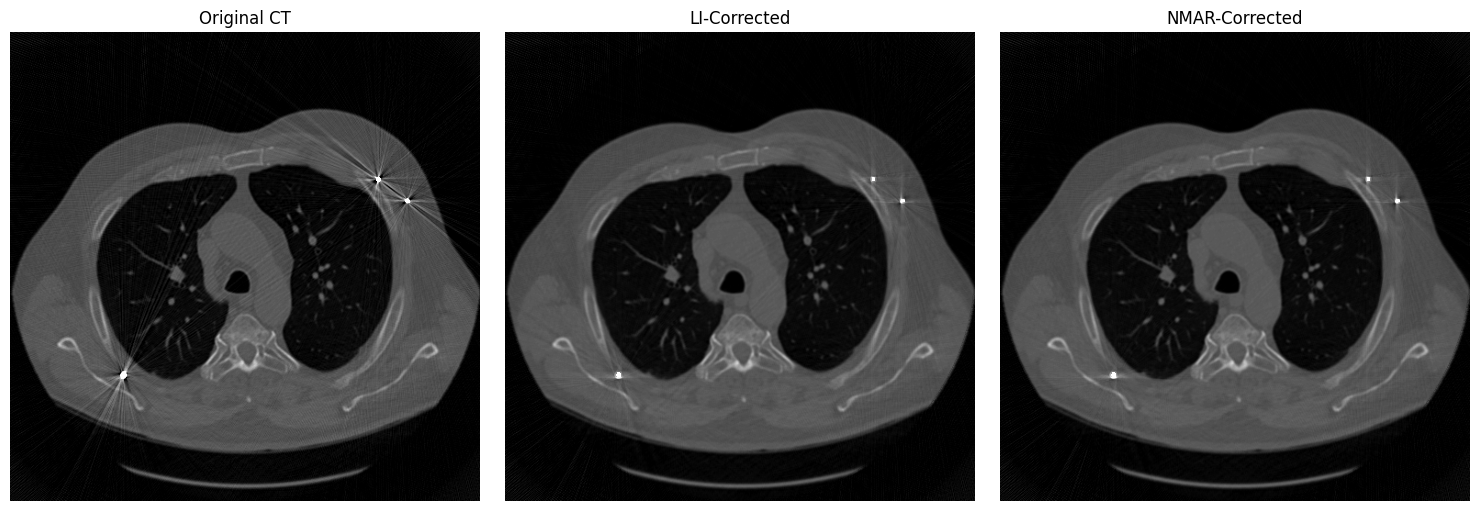

In [6]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.filters import gaussian
from sklearn.cluster import KMeans

# ——— CONFIG ———
CT_FOLDER    = '/home/user/Desktop/Briya/CONVENTIONAL CT/dataset/body1/body1/baseline_npy'
MASK_FOLDER  = '/home/user/Desktop/Briya/CONVENTIONAL CT/dataset/body1/body1/npy files/MAsk_npy'
MIU_AIR      = 0
MIU_WATER    = 0.19

def linear_attenuation(im, reverse=False):
    if not reverse:
        return MIU_WATER * (1 + im / 1000)
    else:
        return (im / MIU_WATER - 1) * 1000

def circle_mask(im):
    H, W = im.shape
    r = min(H, W) // 2
    yy, xx = np.ogrid[:H, :W]
    return (yy - H//2)**2 + (xx - W//2)**2 > r**2

def proj_interp(proj, metal_trace):
    out = np.zeros_like(proj)
    for i in range(proj.shape[1]):
        row      = proj[:, i].copy()
        mt       = metal_trace[:, i]
        bad_idx  = np.nonzero(mt)[0]
        good_idx = np.where(mt == 0)[0]
        row[bad_idx] = np.interp(bad_idx, good_idx, row[good_idx])
        out[:, i]    = row
    return out

def nmar_proj_interp(proj, proj_prior, metal_trace):
    proj_prior[proj_prior < 0] = 0
    eps = 1e-6
    proj_prior = proj_prior + eps
    proj_norm = proj / proj_prior
    proj_norm_interp = proj_interp(proj_norm, metal_trace)
    proj_nmar = proj_norm_interp * proj_prior
    proj_nmar[metal_trace == 0] = proj[metal_trace == 0]
    return proj_nmar

# pick one slice for demonstration
# ct_files = sorted(
#     [f for f in os.listdir(CT_FOLDER) if f.endswith('.npy')],
#     key=lambda fn: int(re.search(r'_img(\d+)_', fn).group(1))
# )
# demo_ct   = ct_files[0]
# demo_mask = demo_ct.replace('metalart', 'metalonlymask')

# load
im = np.fromfile(r"D:\AAPM_MAR_dataset\body9\body9\Baseline\training_body_metalart_img8018_512x512x1.raw", dtype=np.float32).reshape(512, 512)

metal_bw = np.fromfile(r"D:\AAPM_MAR_dataset\body9\body9\Mask\training_body_metalonlymask_img8018_512x512x1.raw", dtype=np.float32).reshape(512, 512).astype(bool)


# common masks
cm = circle_mask(im)

# prepare for projection
im_raw = linear_attenuation(im)
im_raw[cm] = MIU_AIR
theta = np.linspace(0., 180., im.shape[0], endpoint=False)

# forward project
sino       = radon(im_raw, theta=theta, circle=True)
metal_sino = radon(metal_bw.astype(float), theta=theta, circle=True) > 0

# 1) Linear interpolation correction
sino_li = proj_interp(sino, metal_sino)
im_li   = iradon(sino_li, theta=theta, circle=True, filter_name='ramp')

# 2) NMAR: build prior from LI image
im_prior = im_li.copy()
im_prior[metal_bw] = MIU_WATER
# smooth
im_smooth = gaussian(im_prior, sigma=1)
# k-means segmentation
flat = im_prior.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, init=np.array([[MIU_AIR], [MIU_WATER], [2*MIU_WATER]]), n_init=1)
labels = kmeans.fit_predict(flat).reshape(im.shape)
# thresholds
thresh_bone  = max(1.2*MIU_WATER, np.min(im_prior[labels == 2]))
thresh_water = np.min(im_prior[labels == 1])
# build prior image
prior_img = im_smooth.copy()
prior_img[im_smooth <= thresh_water] = MIU_AIR
mask_bone = (im_smooth > thresh_water) & (im_smooth < thresh_bone)
prior_img[mask_bone] = MIU_WATER

# project prior and apply NMAR
proj_prior = radon(prior_img, theta=theta, circle=True)
sino_nmar  = nmar_proj_interp(sino, proj_prior, metal_sino)
im_nmar    = iradon(sino_nmar, theta=theta, circle=True, filter_name='ramp')

# reconstruct to HU
recon_li   = linear_attenuation(im_li, reverse=True)
recon_nmar = linear_attenuation(im_nmar, reverse=True)
recon_li[metal_bw]   = im[metal_bw]; recon_li[cm]   = im[cm]
recon_nmar[metal_bw] = im[metal_bw]; recon_nmar[cm] = im[cm]

# plot all three
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(im, cmap='gray', vmin=-1000, vmax=2000)
axs[0].set_title('Original CT');      axs[0].axis('off')
axs[1].imshow(np.clip(recon_li, im.min(), im.max()), cmap='gray', vmin=-1000, vmax=2000)
axs[1].set_title('LI-Corrected');      axs[1].axis('off')
axs[2].imshow(np.clip(recon_nmar, im.min(), im.max()), cmap='gray', vmin=-1000, vmax=2000)
axs[2].set_title('NMAR-Corrected');    axs[2].axis('off')
plt.tight_layout()
plt.show()
